In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os 

### preprocessing

In [ ]:
import biomart
#comvert ensembl ID to gene symbol
server = biomart.BiomartServer('http://uswest.ensembl.org/biomart',mirror = "useast")    
mart = server.datasets['hsapiens_gene_ensembl']     
attributes = ['ensembl_gene_id','hgnc_symbol']
response = mart.search({'attributes': attributes})                          
data = response.raw.data.decode('ascii')  

## create a conversion table of ensembl id and gene symbol
ensembl_to_genesymbol = {}                                                  
# Store the data in a dict                                                  
for line in data.splitlines():                                              
    line = line.split('\t')                                                 
    # The entries are in the same order as in the `attributes` variable
    transcript_id = line[0]                                                 
    gene_symbol = line[1]                                                                                                
                                                                            
    # Some of these keys may be an empty string. If you want, you can 
    # avoid having a '' key in your dict by ensuring the 
    # transcript/gene/peptide ids have a nonzero length before
    # adding them to the dict
    ensembl_to_genesymbol[gene_symbol] = transcript_id    

ens_id = []
for g in hbv_gene['Gene_symbol'] :
    ens_id.append(ensembl_to_genesymbol[g])   

hbv_conversion_table = pd.DataFrame({'Gene_symbol' : hbv_gene['Gene_symbol'],'Ensembl_ID' :ens_id})
hbv_conversion_table.to_csv(path+'hbv_gene_conversion_table.txt',sep = '\t')      

In [4]:
path = '/home/bruce1996/data/LIHC_anomaly_detection/'

lihc_tumor_exp_profile = path + 'Tumor_matrix_coding_FPKM.txt'
lihc_normal_exp_profile = path + 'Normal_matrix_coding_FPKM.txt'
lihc_tumor = pd.read_csv(lihc_tumor_exp_profile,sep = '\t',index_col=0)
lihc_normal = pd.read_csv(lihc_normal_exp_profile,sep = '\t',index_col=0)
lihc_df = pd.concat([lihc_tumor,lihc_normal],axis = 1)

hbv_conversion_table = pd.read_csv(path + 'lihc/hbv_gene_conversion_table.txt',sep = '\t',index_col=0)
ens_id = hbv_conversion_table['Ensembl_ID'].values        

sample_name =  list(lihc_tumor.columns) + list(lihc_normal.columns)
label =  ['Tumor'] * lihc_tumor.shape[1] + ['Normal'] * lihc_normal.shape[1]
sample_df = pd.DataFrame({'Sample' : sample_name,'Label' : label})

In [50]:
coding_ens = list(lihc_df.index)
target_ens = list(set(ens_id).union(coding_ens))
target_ens = list(map(lambda x : x.split('.')[0],list(target_ens)))

In [52]:
normal_list = os.listdir(path+'lihc/normal_raw')
normal_uq_df = pd.DataFrame()
for idx,f in enumerate(normal_list) :
    name = f.split('-')[2]
    df = pd.read_csv(path+'lihc/normal_raw/'+normal_list[idx],sep = '\t',header=None)
    df.columns = ['Gene',name]
    if idx == 0 :
        normal_uq_df = df
    else :
        normal_uq_df = normal_uq_df.merge(df,on='Gene',how='left')
        
normal_uq_df.index = normal_uq_df['Gene']
normal_uq_df = normal_uq_df.drop(['Gene'],axis=1)

tumor_list = os.listdir(path+'lihc/tumor_raw')
tumor_uq_df = pd.DataFrame()
for idx,f in enumerate(tumor_list) :
    name = f.split('-')[2]
    df = pd.read_csv(path+'lihc/tumor_raw/'+tumor_list[idx],sep = '\t',header=None)
    df.columns = ['Gene',name]
    if idx == 0 :
        tumor_uq_df = df
    else :
        tumor_uq_df = tumor_uq_df.merge(df,on='Gene',how='left')
        
tumor_uq_df.index = tumor_uq_df['Gene']
tumor_uq_df = tumor_uq_df.drop(['Gene'],axis=1)
lihc_df = pd.concat([tumor_uq_df,normal_uq_df],axis=1)
lihc_df.index = list(map(lambda x : x.split('.')[0],list(lihc_df.index)))

#coding gene
lihc_df_subset = lihc_df.loc[target_ens,:]
lihc_df_subset.to_csv(path + 'lihc_coding_gene_exp_profile.txt',sep = '\t')

### demographic table

In [2]:
clinical_info_file = 'nationwidechildrens.org_clinical_patient_lihc.txt'
clinical_info = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/' + clinical_info_file,sep='\t')
clinical_info = clinical_info.drop([0,1],axis=0)
idx = [x.split('-')[-1] for x in clinical_info['bcr_patient_barcode']]
clinical_info.index = idx

In [5]:
idx = [bool(re.search('Hepatitis B Surface Antigen' ,x )) for x in clinical_info.loc[:,'viral_hepatitis_serology'].values]
hbv_positive = clinical_info.loc[idx,'viral_hepatitis_serology'].index
tmp = []
for x in sample_df['Sample'] :
    if x in hbv_positive :
        tmp.append('Positive')
    else :
        tmp.append('Negative')
sample_df['HBV'] = tmp

In [6]:
hbv_idx = sample_df[sample_df['HBV'] == 'Positive'].index

### Standardization

In [14]:
path = '/home/bruce1996/data/LIHC_anomaly_detection/'
lihc_df = pd.read_csv(path + 'lihc_coding_gene_exp_profile.txt',sep = '\t',index_col = 0)
#standardization
lihc_hbv_array = lihc_df.T.to_numpy()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(lihc_hbv_array)
lihc_df_stand = scaler.transform(lihc_hbv_array)

In [9]:
#subset hbv associated gene 
hbv_conversion_table = pd.read_csv(path + 'lihc/hbv_gene_conversion_table.txt',sep = '\t',index_col=0)
ens_id = hbv_conversion_table['Ensembl_ID'].values 

idx = [x.split('.')[0] in ens_id for x in lihc_df.index]
lihc_hbv_array_stand = lihc_df_stand.T[idx,:]
#principle component analysis after standardization
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
pca = PCA(n_components=2)
#hbv_pca = pca.fit(lihc_hbv_array_stand.T).transform(lihc_hbv_array_stand.T)
hbv_pca = pca.fit_transform(lihc_hbv_array_stand)

### Data argumentation

In [ ]:
sum_variance = np.concatenate((np.zeros(48),np.repeat(0.9,48)),axis = 0 )
for i in range(2,50) :
    pca = PCA(n_components=i)
    hbv_pca = pca.fit_transform(lihc_hbv_array_stand)
    sum_variance[i-2] = sum(pca.explained_variance_ratio_)
df = pd.DataFrame({'Explained variance' : sum_variance,'X' : np.concatenate((np.arange(48),np.arange(48)),axis = 48),'Label' : (['LIHC']*48 + ['Threshold']*48) })
plt.figure(figsize=(10,6))
sns.lineplot(data = df ,x = 'X',y='Explained variance',hue = 'Label',style = 'Label',marker = True)
plt.title('Explained variance ratio in different number of principle component')

In [74]:
pca = PCA(n_components=43)
hbv_pca = pca.fit_transform(lihc_hbv_array_stand)

synthesis_data = np.zeros((103,43))
n = 0
for i in range(103) :
    ref = sample(list(np.arange(103)),2)
    r1 = hbv_pca[ref[0],:]
    r2 = hbv_pca[ref[1],:]
    synthesis_data[i,:] = (r1 + r2) / 2

In [ ]:
synthesis = pca.inverse_transform(synthesis_data)

synthesis_array = np.concatenate((lihc_hbv_array_stand,synthesis),axis=0)
pcaa = PCA(n_components=2)
syn_pca = pcaa.fit_transform(synthesis_array)
pca_df = pd.DataFrame({'PC1' : syn_pca[:,0],'PC2' : syn_pca[:,1],'Label' : (['LIHC']*103 +['Synthesis'] * 103)})
plt.figure(figsize=(6,5))
sns.scatterplot(data=pca_df,x='PC1',y='PC2',hue='Label',palette="Set2")
plt.xlabel("PC1 (" + str(round(pcaa.explained_variance_ratio_[0]*100,2))+ "%)")
plt.ylabel("PC2 (" + str(round(pcaa.explained_variance_ratio_[1]*100,2)) + "%)")


### OCSVM

In [5]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score

In [6]:
nu_list = np.arange(0.1,1,.1)
auc_list = np.zeros(9)

X = lihc_hbv_array_stand
test_idx = [x.split('.')[0] not in ens_id for x in lihc_df.index]
x_test = lihc_df_stand.T[test_idx,:]

Y = np.repeat(1,lihc_df.shape[0])
Y[test_idx] = -1

for idx,n in enumerate(nu_list) :
    ocsvm = OneClassSVM(gamma='scale',kernel='rbf',nu = n).fit(X)
    label = ocsvm.predict(lihc_df_stand.T)
    auc_list[idx] = roc_auc_score(Y,label)

df = pd.DataFrame({'nu' : nu_list,'AUC' : auc_list})
plt.figure(figsize=(8,6))
sns.lineplot(data=df,x='nu',y='AUC')
plt.title('AUC of ROC in different nu of OCSVM')

In [18]:
#according to last cell result, nu =0.1 have best performance in AUC measurement
ocsvm = OneClassSVM(gamma='scale',kernel='rbf',nu = 0.1).fit(X)
label = ocsvm.predict(lihc_df_stand.T)
idx = label == 1
ocsvm_pos = list(lihc_df.index[idx])

NameError: name 'output_path' is not defined

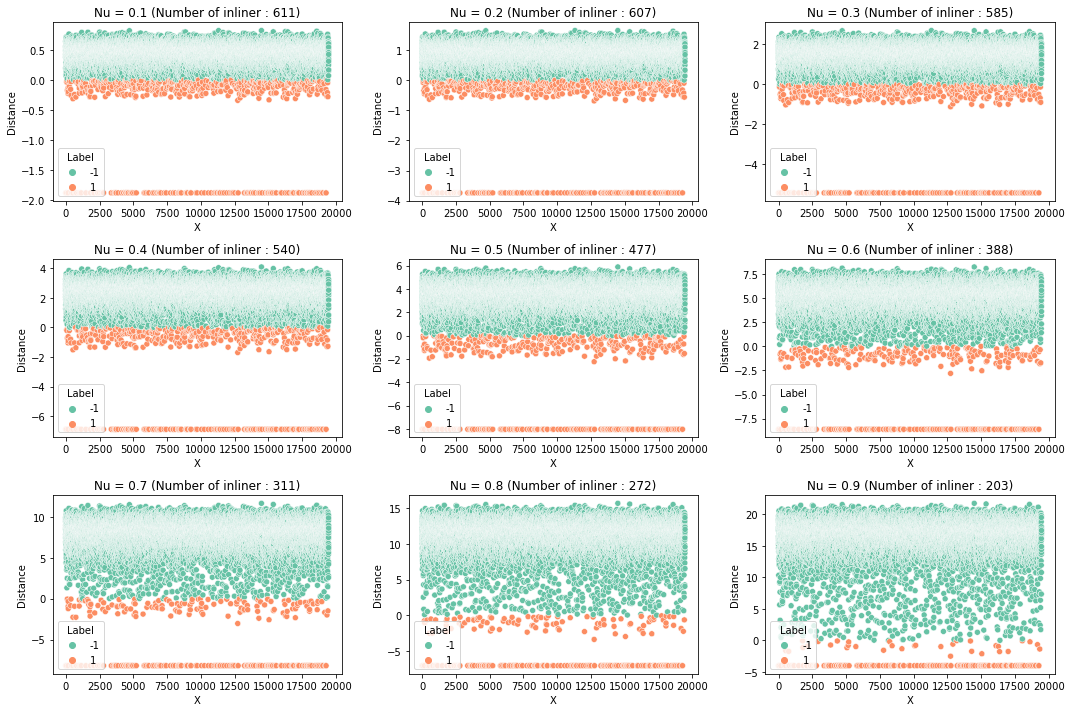

In [ ]:
nu_list = np.arange(0.1,1,.1)

fig, axs = plt.subplots(3,3, figsize=(15, 10))
axs = axs.ravel()

X = lihc_hbv_array_stand
test_idx = [x.split('.')[0] not in ens_id for x in lihc_df.index]
x_test = lihc_df_stand.T[test_idx,:]

for idx,n in enumerate(nu_list) :

    ocsvm = OneClassSVM(gamma='scale',kernel='rbf',nu = n).fit(X)
    label = ocsvm.predict(x_test)
    distance = ocsvm.decision_function(x_test) * -1
    xaxis = np.arange(len(distance))
    y = distance
    df = pd.DataFrame({'X' : xaxis,'Distance' : distance,'Label' : label})
    sns.scatterplot(data = df,x = 'X',y = 'Distance',hue='Label',palette='Set2',ax = axs[idx])
    n_inliner = sum(label == 1)
    axs[idx].set_title('Nu = %0.1f (Number of inliner : %d)' %(n,n_inliner) )

plt.tight_layout()
#plt.savefig(output_path + 'differ_nu_ocsvm_result_in_negative_dataset.png',dpi = 300)


### Ensemble learning

In [15]:
#subset hbv associated gene 
idx = [x.split('.')[0] in ens_id for x in lihc_df.index]
lihc_hbv = lihc_df_stand.T[idx,:]
n_idx = [x == False for x in idx]
lihc_no_hbv = lihc_df_stand.T[n_idx,:]

In [16]:
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import precision_score,confusion_matrix
import multiprocessing as mp

In [25]:
def specificity(y_true,y_pred) :
    tn, fp, _, _ = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    return specificity

def npv(y_true,y_pred) :
    tn, _, fn, _ = confusion_matrix(y_true, y_pred).ravel()
    npv = tn / (tn+fn)
    return npv

In [31]:
class svm_ensemble_learning() :
    def __init__(self,p_m,n_m,all_m,y_all,r = 1,t = 20):
        self.positive_matrix = p_m
        self.negative_matrix = n_m
        self.overall_matrix = all_m
        self.y_overall = y_all
        self.ratio = r
        self.threads = t
        
    def single_svm(self,n) :
        p_array = np.zeros(4)
        population = range(self.negative_matrix.shape[0])
        n_sample = self.ratio * self.positive_matrix.shape[0]
        idx = random.sample(population,n_sample)
        negative = self.negative_matrix[idx,:]
        positive = self.positive_matrix
        X = np.concatenate((positive,negative))
        y = np.concatenate((np.repeat(1,positive.shape[0]),np.repeat(0,negative.shape[0]) ))

        x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)
        svm = SVC(kernel='linear')
        svm.fit(x_train,y_train)
        #prediction and measure model performance
        y_pred = svm.predict(x_test)
        p_array[0] = precision_score(y_test,y_pred,average='binary')
        y_pred_overall = svm.predict(self.overall_matrix)
        p_array[1] = precision_score(y_overall,y_pred_overall,average= 'binary')
        #NPV for negative performance
        p_array[2] = npv(y_test,y_pred)
        p_array[3] = npv(y_overall,y_pred_overall)

        return p_array

    def ensemble_svm(self) :
        pool = mp.Pool(self.threads)
        n_run = 1000
        result = pool.map(self.single_svm,range(n_run))
        pool.close()
        pool.join()
        #merge parallel result
        metric_array = np.stack(result,axis = 0)
        metric_df = pd.DataFrame(metric_array,columns = ['Precision','Precision_overall','NPV','NPV_overall'])
        metric_df['Ratio'] = [str(self.ratio)] * n_run

        return metric_df

In [35]:
y_overall = np.zeros(lihc_df_stand.T.shape[0])
idx = [x.split('.')[0] in ens_id for x in lihc_df.index]
y_overall[idx] = 1

svm_ensemble = svm_ensemble_learning(lihc_hbv,lihc_no_hbv,lihc_df_stand.T,y_overall,t = 40)

ratio = np.arange(1,6,1)
metric_df = pd.DataFrame()
for r in ratio :
    svm_ensemble.ratio = r
    df = svm_ensemble.ensemble_svm()
    metric_df = pd.concat([metric_df,df],axis = 0)

In [ ]:
box_df = metric_df.melt(id_vars='Ratio')
box_df.columns = ['Ratio','Metric','Value']
plt.figure(figsize=(15,6))
sns.boxplot(data = box_df,x = 'Ratio',y='Value',hue = 'Metric',palette='Set3')
plt.title('LIHC anomaly detection by ensemble learning in different positive/negative ratio')
output_path = '/home/bruce1996/data/LIHC_anomaly_detection/tmp/'
#plt.savefig(output_path + 'lihc_ae_ensemble_boxplot_n_1000.png',dpi = 300)

In [94]:
#subset by sample have HBV surface antigen
lihc_hbv_hbv_subset = lihc_hbv[:,hbv_idx]
lihc_no_hbv_hbv_subset = lihc_no_hbv[:,hbv_idx]
lihc_df_hbv_subset = lihc_df_stand.T[:,hbv_idx]

In [97]:
y_overall = np.zeros(lihc_df_stand.T.shape[0])
idx = [x.split('.')[0] in ens_id for x in lihc_df.index]
y_overall[idx] = 1

svm_ensemble = svm_ensemble_learning(lihc_hbv_hbv_subset,lihc_no_hbv_hbv_subset,lihc_df_hbv_subset,y_overall,t = 40)

ratio = np.arange(5,55,5)
metric_df = pd.DataFrame()
for r in ratio :
    svm_ensemble.ratio = r
    df = svm_ensemble.ensemble_svm()
    metric_df = pd.concat([metric_df,df],axis = 0)

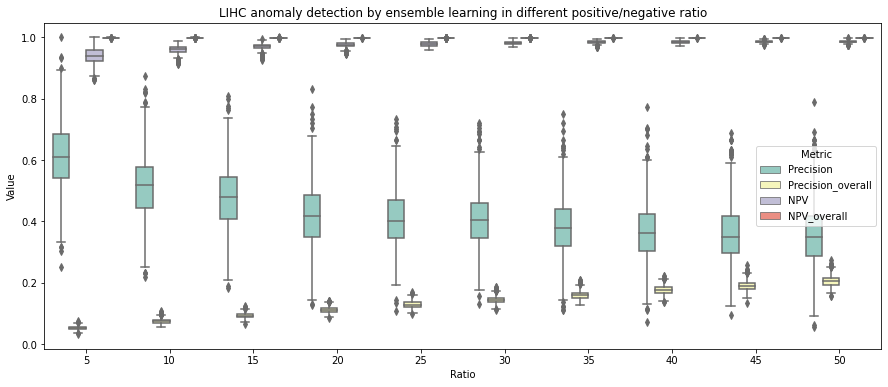

In [99]:
box_df = metric_df.melt(id_vars='Ratio')
box_df.columns = ['Ratio','Metric','Value']
plt.figure(figsize=(15,6))
sns.boxplot(data = box_df,x = 'Ratio',y='Value',hue = 'Metric',palette='Set3')
plt.title('LIHC anomaly detection by ensemble learning in different positive/negative ratio')
output_path = '/home/bruce1996/data/LIHC_anomaly_detection/tmp/'
plt.savefig(output_path + 'lihc_ae_ensemble_boxplot_only_HBV_positive.png',dpi = 300)

### ensemble result

In [10]:
r_path = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/'
r = np.load(r_path + 'lihc_ensemble_result_ratio_5_test_0.npy')

In [11]:
path = '/home/bruce1996/data/LIHC_anomaly_detection/'
x =  path + 'lihc_coding_gene_exp_profile.txt'
#lihc_df = pd.read_csv(x,sep = '\t',index_col=0)
conversion_table_p = path + 'lihc/hbv_gene_conversion_table.txt'
hbv_conversion_table = pd.read_csv(conversion_table_p,sep = '\t',index_col=0)
ens_id = hbv_conversion_table['Ensembl_ID'].values

In [33]:
hbv_idx = [i in ens_id for i in lihc_df.index]
y_overall = np.zeros(lihc_df.shape[0])
y_overall[hbv_idx] = 1

In [15]:
def specificity(y_true,y_pred) :
    tn, fp, _, _ = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    return specificity

def sensitivity(y_true,y_pred) :
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp+fn)
    return sensitivity

def ppv(y_true,y_pred) :
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    ppv = tp / (tp + fp)
    return ppv

def npv(y_true,y_pred) :
    tn, _, fn, _ = confusion_matrix(y_true, y_pred).ravel()
    npv = tn / (tn+fn)
    return npv

In [21]:
from sklearn.metrics import precision_score,f1_score,recall_score,confusion_matrix

def ensemble_vote(result_path,y_overall,ratio,run,threshold) :
    f1 = []
    ratio_all = []
    sp = []
    ppv_r = []
    for i in ratio :
        for r in range(run) :
            ratio_all.append(i)
            file_name = result_path + 'lihc_ensemble_result_ratio_' + str(i) + '_test_' + str(r) + '.npy'
            result = np.load(file_name)
            positive_idx = result >= threshold
            result[positive_idx] = 1
            result[~positive_idx] = 0
            f1.append(f1_score(y_overall,result))
            sp.append(specificity(y_overall,result))
            ppv_r.append(precision_score(y_overall,result))
            
    df = pd.DataFrame({'Ratio' : ratio_all,'F1-score' : f1,'Specificity' : sp,'Precision' : ppv_r})

    return df

Text(0.5, 1.0, 'Ensemble learning performance, threshold : 500')

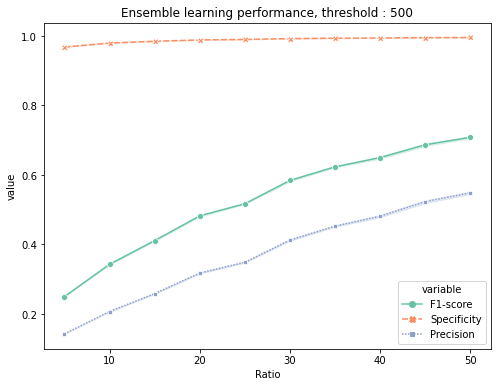

In [106]:
ratio = np.arange(5,55,5)
threshold = 500
df = ensemble_vote(r_path,y_overall,ratio,10,threshold)
plot_df = df.melt(id_vars="Ratio")
plt.figure(figsize=(8,6))
sns.lineplot(data = plot_df ,x="Ratio",y = 'value',hue='variable',style = 'variable',palette="Set2",markers=True)
plt.title("Ensemble learning performance, threshold : %d" % (threshold+1))

In [23]:
def ensemble_result(result_path,threshold,ratio,n_run,n_sample,binary_flag = False) :

    p_r = np.zeros(n_sample)

    for i in range(n_run) :
        file_name = result_path + 'lihc_ensemble_result_ratio_' + str(ratio) + '_test_' + str(i) + '.npy'
        result = np.load(file_name)
        if binary_flag :
            positive_idx = result >= threshold
            result[positive_idx] = 1
            result[~positive_idx] = 0
        
        p_r = p_r + result

    return p_r

In [35]:
ratio = np.arange(5,55,5)
result_path = r_path
vote_df = pd.DataFrame()
for r in ratio :
    result = ensemble_result(result_path,0,r,10,19560)
    hbv_vote = result[hbv_idx]
    df = pd.DataFrame({'ID' : lihc_df.index[hbv_idx],'Ratio' : [r]*103,'Vote' : hbv_vote})
    vote_df = pd.concat([vote_df,df],axis = 0)

<AxesSubplot:xlabel='Ratio', ylabel='Vote'>

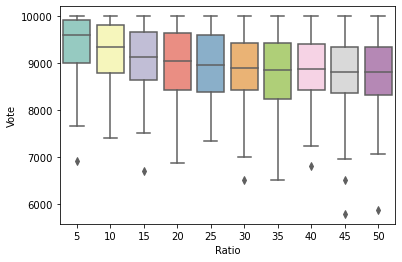

In [39]:
sns.boxplot(data = vote_df,x = 'Ratio',y='Vote',palette = "Set3")

In [27]:
ensemble_vote_of_np_25 = ensemble_result(r_path,499,25,10,19560)
idx = ensemble_vote_of_np_25 > 0
ensemble_pos_np_25 = list(lihc_df.index[idx])
#
candidate_gene = list(set(ocsvm_pos).intersection(ensemble_pos_np_25))
for x in candidate_gene :
    if x in ens_id :
        candidate_gene.remove(x)

(400.0, 1000.0)

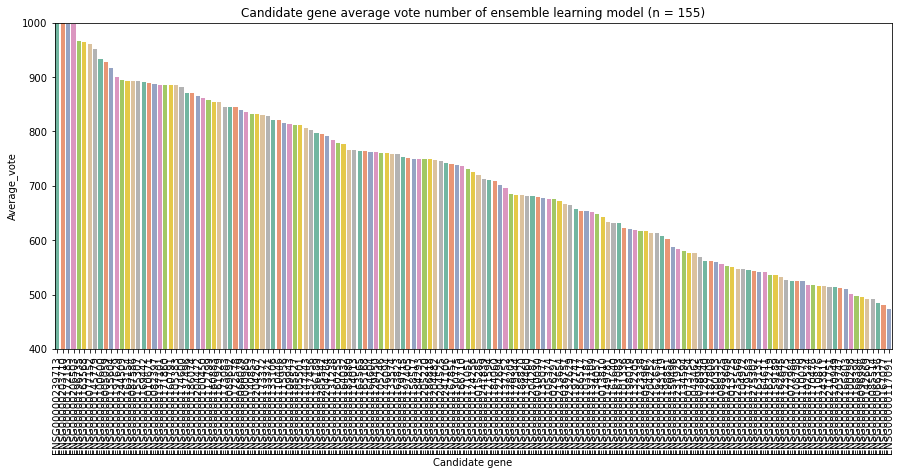

In [51]:
ensemble_vote_of_np_25 = ensemble_result(r_path,499,25,10,19560)
idx = [x in candidate_gene for x in lihc_df.index]
vote  = ensemble_vote_of_np_25[idx] / 10
df = pd.DataFrame({'Candidate gene' : candidate_gene,'Average_vote' : vote})
df = df.sort_values(by='Average_vote',ascending = False)
plt.figure(figsize=(15,6))
sns.barplot(data=df ,x = 'Candidate gene',y='Average_vote',palette="Set2")
plt.xticks(rotation=90)
plt.title("Candidate gene average vote number of ensemble learning model (n = 155)")
plt.ylim((400,1000))

Text(0, 0.5, 'PC2 (11.69%)')

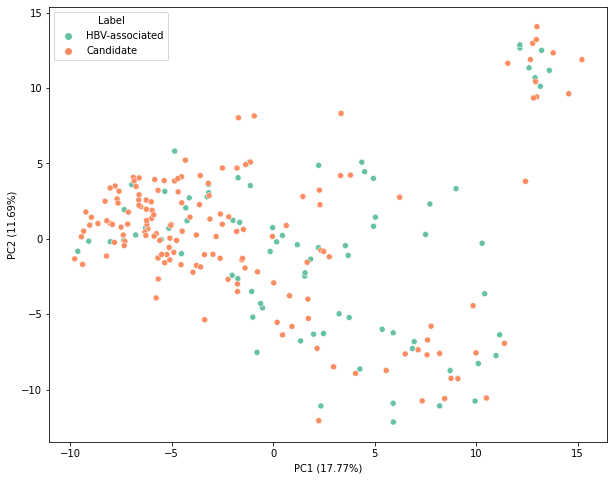

In [58]:
hbv_idx = [x in ens_id for x in lihc_df.index]
candidate_idx = [x in candidate_gene for x in lihc_df.index]

lihc_hbv_array_stand = lihc_df_stand.T[hbv_idx,:]
lihc_candidate_array = lihc_df_stand.T[candidate_idx]
x = np.concatenate((lihc_hbv_array_stand,lihc_candidate_array),axis = 0)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(x)
pca_df = pd.DataFrame(pca_result)
pca_df.columns = ['PC1','PC2']
pca_df['Label'] = ['HBV-associated']*103 + ['Candidate'] * 155

plt.figure(figsize=(10,8))
sns.scatterplot(data=pca_df,x='PC1',y='PC2',hue='Label',palette='Set2')
plt.xlabel("PC1 (" + str(round(pca.explained_variance_ratio_[0]*100,2)) + "%)")
plt.ylabel("PC2 (" + str(round(pca.explained_variance_ratio_[1]*100,2)) + "%)")

In [74]:
ratio = np.arange(5,55,5)
threshold = np.arange(0,1100,100)
rr = []
tt = []
nfp = []
for r in ratio :
    for t in threshold :
        fp = ensemble_result_fp(r_path,t,r,10,19560)
        n_fp = np.sum(fp > 0)
        rr.append(r)
        tt.append(t)
        nfp.append(n_fp)
        
df = pd.DataFrame({"Ratio" : rr,"Threshold" : tt, "Number" : nfp})

plt.figure(figsize=(10,6))
sns.lineplot(data=df,x="Ratio",y = 'Number',hue='Threshold',style='Threshold',palette="Set2",markers=True)
plt.ylim(0,3500)

In [11]:
from sklearn.decomposition import PCA,KernelPCA

r = 5
pos_r = ensemble_result_fp(r_path,0,r,10,19560)
pos_df = lihc_df.loc[pos_r > 0,:]
pos_df

tp_idx = [x in ens_id for x in pos_df.index]
label = pd.Series(['False Positive'] * pos_df.shape[0])
label[tp_idx] = "True Positive"
pca = KernelPCA(n_components=2,kernel='rbf')
pos_pca = pca.fit(pos_df.to_numpy()).transform(pos_df.to_numpy())

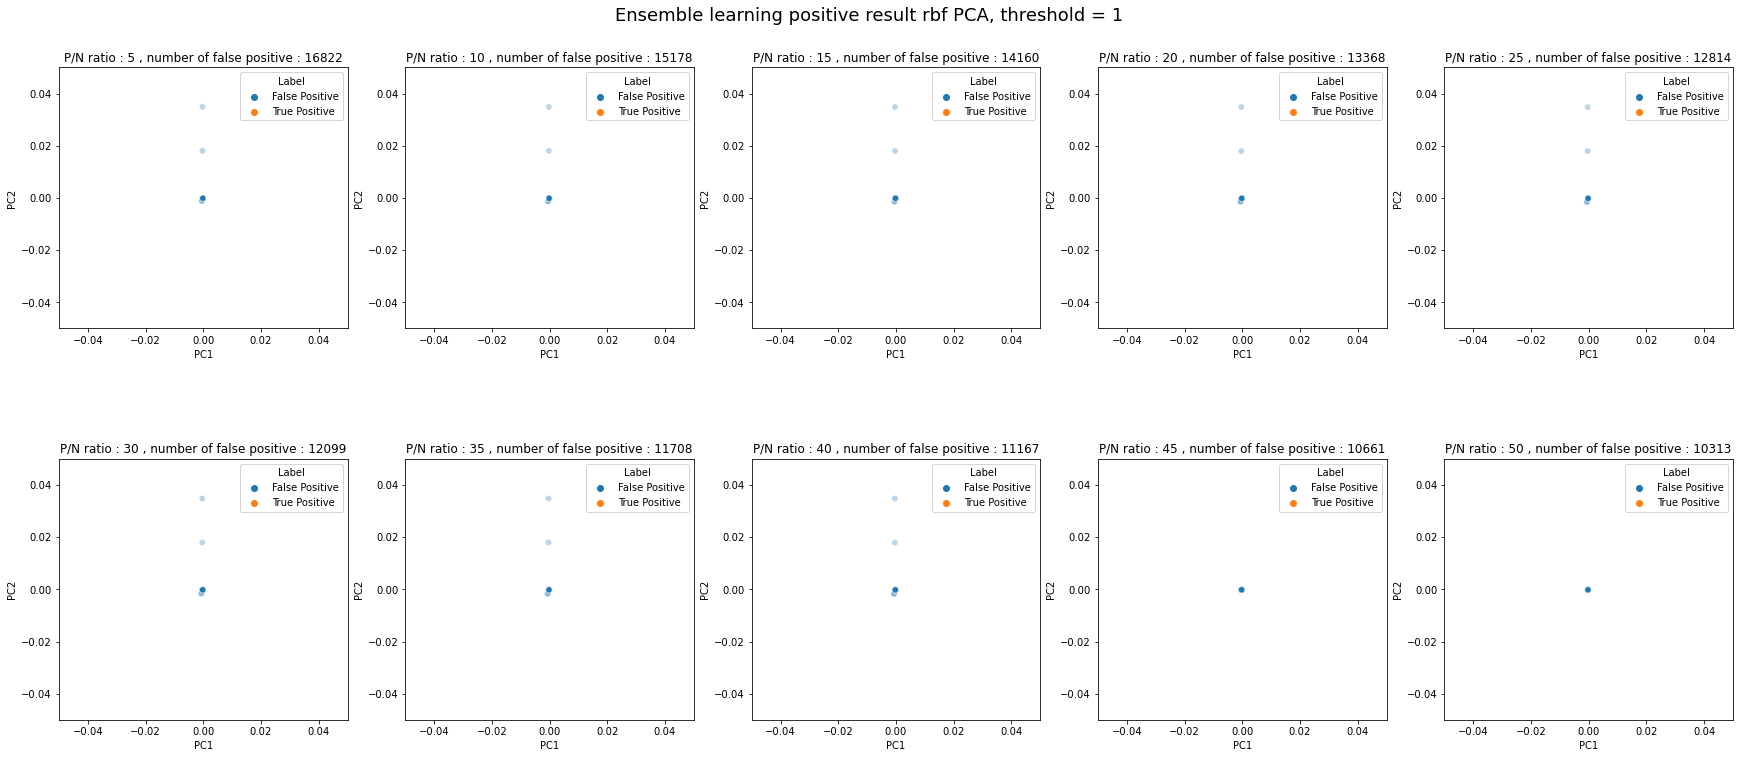

In [27]:
output_path = '/home/bruce1996/data/LIHC_anomaly_detection/tmp/'

kernel = 'rbf'
threshold = 0
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(30, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Ensemble learning positive result %s PCA, threshold = %d" % (kernel,threshold+1), fontsize=18, y=0.95)

rr = np.arange(5,55,5)

for r,ax in zip(rr,axs.ravel()) :
    
    pos_r = ensemble_result_fp(r_path,threshold,r,10,19560)
    pos_df = lihc_df.loc[pos_r > 0,:]
    tp_idx = [x in ens_id for x in pos_df.index]
    label = pd.Series(['False Positive'] * pos_df.shape[0])
    label[tp_idx] = "True Positive"
    pca = KernelPCA(n_components=2,kernel=kernel)
    pos_pca = pca.fit(pos_df.to_numpy()).transform(pos_df.to_numpy())

    pca_df = pd.DataFrame()
    pca_df['PC1'] = pos_pca[:,0]
    pca_df['PC2'] = pos_pca[:,1]
    pca_df['Label'] = label
    
    sns.scatterplot(data = pca_df,x = 'PC1',y = 'PC2',hue = 'Label',ax=ax,alpha=0.3)
    n_fp = pca_df.shape[0] - 103
    ax.set_xlim(-0.05,0.05)
    ax.set_ylim(-0.05,0.05)
    ax.set_title('P/N ratio : %s , number of false positive : %d' % (str(r),n_fp) )

plt.savefig(output_path + 'Positive_result_'+kernel+'_pca_threshold_' + str(threshold + 1) + '.png',dpi = 300)